In [1]:
import numpy as np
import scipy as sc
import numpy.linalg as npl
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%load_ext line_profiler

# Dev forces

In [239]:
def get_numerical_force(pot_func,r,*args):
    from numpy.linalg import norm
    e_x,e_y,e_z = np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1])
    h = 1e-6
    F_x = - ( pot_func(norm(r+e_x*h),*args) - pot_func(norm(r-e_x*h),*args) )  / (2*h)
    F_y = - ( pot_func(norm(r+e_y*h),*args) - pot_func(norm(r-e_y*h),*args) )  / (2*h)
    F_z = - ( pot_func(norm(r+e_z*h),*args) - pot_func(norm(r-e_z*h),*args) )  / (2*h)
    return np.array([F_x,F_y,F_z])

In [258]:
def Potentiel_Harmonique(d,r_m,k):
    ''' '''
    return k*( d - r_m)**2
def Potentiel_LennardJones(d,r_m,epsilon):
    ''' '''
    return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)

## get forces simple

$\mathbf{F}_{LJ}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{LJ}\left(d\right) = \mathbf{\hat{r}}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right] $

### lj

In [422]:
def get_LJ_forces_simple(positions,r_m,epsilon):
    Npart,_ = positions.shape
    dist = squareform(pdist(positions))
    forces = np.zeros(positions.shape)
    energy = 0.0
    dd = np.zeros((positions.shape[0]-1))
    r = np.zeros((positions.shape[0]-1,3))
    for ipart in range(Npart):
        r[ipart:] = positions[ipart+1:] - positions[ipart]
        r[:ipart] = positions[:ipart] - positions[ipart]
        
        dd[ipart:] = dist[ipart,ipart+1:]
        dd[:ipart] = dist[ipart,:ipart]
        
        c6 = np.power(r_m/dd,6)
        c12 = np.power(c6,2)
        
        energy += epsilon * (c12 - 2*c6).sum()
        
        factor = 12*epsilon/dd**2
        fs = -(factor*(c12-c6)).reshape((-1,1)) * r 
        forces[ipart] += fs.sum(axis=0)
        #forces[ipart+1:] += fs
    energy = 0.5*energy
    return forces,energy

In [251]:
r_m,epsilon = 0.2,1
positions = np.random.rand(4,3)
get_LJ_forces_simple(positions,r_m,epsilon)

(array([[ 8.71049111e+01,  7.32256876e+02, -6.27765746e+01],
        [ 3.44370400e-02, -1.13149548e-03,  7.20524040e-02],
        [-2.55023823e-02, -5.04551085e-02,  1.08705927e-02],
        [-8.71138458e+01, -7.32205289e+02,  6.26936517e+01]]),
 6.2196964865740885)

In [252]:
F_num = np.zeros(positions.shape)
energy = 0
for ii,p1 in enumerate(positions):
    for jj,p2 in enumerate(positions):
        if jj != ii:
            r = p2-p1
            F_num[ii] += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
            energy += Potentiel_LennardJones(np.linalg.norm(r),r_m,epsilon)*0.5
F_num,energy

(array([[ 8.71049111e+01,  7.32256877e+02, -6.27765746e+01],
        [ 3.44370400e-02, -1.13149548e-03,  7.20524040e-02],
        [-2.55023823e-02, -5.04551085e-02,  1.08705927e-02],
        [-8.71138458e+01, -7.32205290e+02,  6.26936516e+01]]),
 6.219696486574091)

### harm

In [341]:
def get_Harm_forces_simple(positions,r_m,k_spring):
    Npart,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0.0
    for ii in range(Npart):
        if ii < Npart-1:
            r = positions[ii+1] - positions[ii]
            d = np.linalg.norm(r)
            f = - 2 * k_spring * (d-r_m)
            forces[ii] -= r/d * f
            energy += k_spring * (d-r_m)**2
        if ii  > 0:
            r = positions[ii-1] - positions[ii]
            d = np.linalg.norm(r)
            f = - 2 * k_spring * (d-r_m)
            forces[ii] -= r/d * f
            
    
    return forces,energy

In [342]:
r_m,k_spring = 0.2,1
positions = np.random.rand(4,3)
get_Harm_forces_simple(positions,r_m,k_spring)

(array([[-0.82575038,  0.38933746, -0.26052915],
        [ 0.82708799, -0.465418  ,  0.73755648],
        [-0.03385471, -0.06289112, -0.4124867 ],
        [ 0.0325171 ,  0.13897166, -0.06454063]]), 0.28980096970183794)

In [343]:
F_num = np.zeros(positions.shape)
energy = 0
for ii in range(positions.shape[0]):
    if ii < positions.shape[0]-1:
        r = positions[ii+1] - positions[ii]
        F_num[ii] += get_numerical_force(Potentiel_Harmonique,r,*[r_m,k_spring])
        energy += Potentiel_Harmonique(np.linalg.norm(r),r_m,k_spring)
    if ii  > 0:
        r = positions[ii-1] - positions[ii]
        F_num[ii] += get_numerical_force(Potentiel_Harmonique,r,*[r_m,k_spring])
        
F_num,energy

(array([[ 0.82575038, -0.38933746,  0.26052915],
        [-0.82708799,  0.465418  , -0.73755648],
        [ 0.03385471,  0.06289112,  0.4124867 ],
        [-0.0325171 , -0.13897166,  0.06454063]]), 0.28980096970183794)

## get forces opt

### lj

In [423]:
def get_LJ_forces(positions,r_m,epsilon):
    Npart,_ = positions.shape
    #dist = squareform(pdist(positions))
    forces = np.zeros(positions.shape)
    energy = 0.0
    r_m2 = r_m**2
    for ipart in range(Npart-1):
        r = positions[ipart+1:] - positions[ipart]
        d2 = np.power(r,2).sum(axis=1)
        c6 = np.power(r_m2/d2,3)
        c12 = np.power(c6,2)
        
        energy += epsilon * (c12 - 2*c6).sum()
        
        factor = 12*epsilon/d2
        fs = -(factor*(c12-c6)).reshape((-1,1)) * r 
        forces[ipart] += fs.sum(axis=0)
        forces[ipart+1:] -= fs
    energy = energy
    return forces,energy

In [465]:
def get_LJ_forces_new(positions,r_m,epsilon):
    Npart,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0.0
    r_m6 = r_m**6
    r_m12 = r_m**12
    factor = -12*epsilon
    
    dirVec = np.zeros((int(Npart*(Npart+1)/2-Npart),3))
    stride = np.cumsum([0]+[it for it in range(Npart-1,0,-1)])
    iparts = range(len(stride[:-1]))
    for ipart, st, nd in zip(iparts, stride[:-1], stride[1:]):
        dirVec[st:nd,:] = positions[ipart+1:] - positions[ipart]
    
    d2 = np.power(dirVec,2).sum(axis=1)
    c2 = np.power(d2,-1)
    c6 = r_m6*np.power(c2,3)
    c12 = np.power(c6,2)
    energy = epsilon * (c12 - 2*c6).sum()
    fs = (factor*(c12-c6)*c2 ).reshape((-1,1))* dirVec
    
    for ipart, st, nd in zip(iparts, stride[:-1], stride[1:]):
        forces[ipart] += fs[st:nd].sum(axis=0)
        forces[ipart+1:] -= fs[st:nd]
    energy = energy
    return forces,energy

In [466]:
r_m,epsilon = 0.8,1
positions = np.random.rand(4,3)
get_LJ_forces_simple(positions,r_m,epsilon)

(array([[ 1.09439537e+03, -8.72030361e+02,  4.99590294e+03],
        [-7.25457990e+06,  4.08140995e+06,  3.73960678e+06],
        [ 5.93094936e+01,  7.57969286e+02, -6.05304958e+02],
        [ 7.25342619e+06, -4.08129589e+06, -3.74399737e+06]]),
 218136.48388157634)

In [467]:
get_LJ_forces(positions,r_m,epsilon)

(array([[ 1.09439537e+03, -8.72030361e+02,  4.99590294e+03],
        [-7.25457990e+06,  4.08140995e+06,  3.73960678e+06],
        [ 5.93094936e+01,  7.57969286e+02, -6.05304958e+02],
        [ 7.25342619e+06, -4.08129589e+06, -3.74399737e+06]]),
 218136.48388157628)

In [468]:
get_LJ_forces_new(positions,r_m,epsilon)

(array([[ 1.09439537e+03, -8.72030361e+02,  4.99590294e+03],
        [-7.25457990e+06,  4.08140995e+06,  3.73960678e+06],
        [ 5.93094936e+01,  7.57969286e+02, -6.05304958e+02],
        [ 7.25342619e+06, -4.08129589e+06, -3.74399737e+06]]),
 218136.48388157616)

In [469]:
r_m,epsilon = 0.2,1
positions = np.random.rand(100,3)
%timeit -n 10 -r 3 get_LJ_forces_simple(positions,r_m,epsilon)
%timeit -n 10 -r 3 get_LJ_forces(positions,r_m,epsilon)
%timeit -n 10 -r 3 get_LJ_forces_new(positions,r_m,epsilon)

4.65 ms ± 92.7 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
3.69 ms ± 29.3 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
1.84 ms ± 42.4 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [470]:
%lprun -f get_LJ_forces_new get_LJ_forces_new(positions,r_m,epsilon)

### harm

In [625]:
def get_Harm_forces(positions,r_m,k_spring):
    Npart,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0.0
    r = positions[1:] - positions[:-1]
    d = np.linalg.norm(r,axis=1)
    f = (- 2 * k_spring * (d-r_m)/d).reshape((-1,1))
    rf = r * f
    forces[:Npart-1] -= rf
    forces[1:] += rf
    energy = k_spring * ((d-r_m)**2).sum()
    return forces,energy

In [630]:
r_m,k_spring = 0.5,10
positions = np.random.rand(5,3)
get_Harm_forces_simple(positions,r_m,k_spring)

(array([[  2.41655002,  -0.8133068 ,   0.68590926],
        [ -3.15363821,  -6.63539248,   5.94455865],
        [  5.17485324,   8.89031664, -10.52319975],
        [ -4.49307633,  -1.48228086,   3.81402648],
        [  0.05531128,   0.0406635 ,   0.07870536]]), 3.597436652143596)

In [631]:
get_Harm_forces(positions,r_m,k_spring)

(array([[  2.41655002,  -0.8133068 ,   0.68590926],
        [ -3.15363821,  -6.63539248,   5.94455865],
        [  5.17485324,   8.89031664, -10.52319975],
        [ -4.49307633,  -1.48228086,   3.81402648],
        [  0.05531128,   0.0406635 ,   0.07870536]]), 3.5974366521435956)

In [632]:
r_m,epsilon = 0.2,1
positions = np.random.rand(5,3)
%timeit -n 10 -r 3 get_Harm_forces_simple(positions,r_m,k_spring)
%timeit -n 10 -r 3 get_Harm_forces(positions,r_m,k_spring)

175 µs ± 7.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
33.2 µs ± 3.1 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


# get all forces

In [634]:
def get_forces_simple(positions,r_m,epsilon,k_spring):
    LJ_forces,LJ_pot = get_LJ_forces_simple(positions,r_m,epsilon)
    H_forces,H_pot = get_Harm_forces_simple(positions,r_m,k_spring)
    return LJ_forces+H_forces,LJ_pot,H_pot

In [633]:
def get_forces(positions,r_m,epsilon,k_spring):
    LJ_forces,LJ_pot = get_LJ_forces(positions,r_m,epsilon)
    H_forces,H_pot = get_Harm_forces(positions,r_m,k_spring)
    return LJ_forces+H_forces,LJ_pot,H_pot

# OLD

In [6]:
def calcule_r_et_d(positions):
    Nparticule,_ = positions.shape
    # matrice des distances
    distances2 = np.zeros((Nparticule,Nparticule-1))
    # matrice des vecteurs de direction
    sepVec = np.zeros((Nparticule,Nparticule-1,3))
    # TODO
    dd_diag = np.zeros((Nparticule-1))
    sepVec_diag = np.zeros((Nparticule-1,3))
    for ii in range(Nparticule-1):
        # calcule les vecteurs d'orientation: pour chaque position prendre la difference avec les autres positions
        rr = positions[ii] - positions[ii+1:]
        # calcule la norme des vecteur d'orientation
        dd = np.power(rr,2).sum(axis=1)
        dd_diag[ii] = np.sqrt(dd[0])
        sepVec_diag[ii] = rr[0] / dd_diag[ii]
        # distances2[ii,ii+1:] = distances2[ii+1:,ii] = dd
        distances2[ii,ii:] = distances2[ii+1:,ii] = dd
        #distances2[ii+1:,ii] = dd
        # normalise les vecteurs d'orientation
        sepVec[ii,ii:,:] = rr 
        sepVec[ii+1:,ii,:] = - sepVec[ii,ii:,:]
    return distances2,sepVec,dd_diag,sepVec_diag

$\mathbf{F}_{LJ}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{LJ}\left(d\right) = \mathbf{\hat{r}}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right] $

In [7]:
def get_forces_LJ(distances2,sepVec,r_m,epsilon,forces):
    Natom,_ = positions.shape
    #forces = np.zeros((Natom,3))
    r_m2 = r_m**2
    epsi = 12*epsilon
    pot = 0
    for iatom in range(Natom):
        c6 = np.power(np.divide(r_m2,distances2[iatom]),3)
        c12 = np.power(c6,2)
        fac = np.multiply(np.divide(epsi,distances2[iatom]),np.subtract(c12,c6)).reshape((1,-1,1))
        forces[iatom] += np.sum(np.multiply(sepVec[iatom],fac),axis=1).flatten()
        #if iatom == 1:
        pot += 0.5*np.sum(epsilon*np.subtract(c12,2*c6))
    return pot

$\mathbf{F}_{Har}\left(\mathbf{r}\right)  = \mathbf{\hat{r}} \,F_{Har}\left(d\right) =  - 2 k \, (d - r_m)  \mathbf{\hat{r}} $


In [185]:
def get_forces_polymer_alt(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    pp2 = np.empty(positions.shape)
    pp1 = positions
    pp2[:-1] = positions[1:]
    pp2[-1] = positions[0]
    
    r = np.subtract(pp1,pp2)
    norms = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,norms)
    ffs = - np.multiply(k_spring, np.multiply(np.subtract(norms, r_m), direction_vectors))
    # st = range(Natom)
    # nd = list(range(1,Natom))+[0]
    st = range(Natom-1)
    nd = list(range(1,Natom))
    for ff,it,jt in zip(ffs,st,nd):
        forces[it] += ff
        forces[jt] -= ff
        
        
    return forces

In [8]:
def get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces):
    
    force_resort = np.multiply( -2*k_spring*(dd_diag-r_m).reshape((-1,1)),sepVec_diag)
    forces[:-1] += force_resort
    forces[1:] -= force_resort
    pot = np.sum( k_spring*(dd_diag-r_m)**2 )
    return pot

In [10]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1]]),0.8,1.,1.
#positions,r_m,epsilon,k_spring = np.array([[0,0,0],[0.9,1.3,0.99]]),1.2,1.,1

In [11]:
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

In [12]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1]]),0.8,1.,1.
rot = rotation_matrix([0,1,1],np.pi*0.)
positions = np.dot(positions,rot)
np.linalg.norm(positions[1]-positions[0])

1.0

In [12]:
Nparticule = len(positions)
distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)

### check lj

In [109]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1],[1,1,1]]),1.,1.,1.
#positions,r_m,epsilon,k_spring = np.array([[0,0,0],[0.9,1.3,0.99]]),1.2,1.,1

In [110]:
positions = np.random.rand(4,3)

In [111]:
r = positions[1]-positions[0]
ppp = 0
F_num = get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
ppp += Potentiel_LennardJones(np.linalg.norm(r),*[r_m,epsilon])
r = positions[1]-positions[2]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
ppp += Potentiel_LennardJones(np.linalg.norm(r),*[r_m,epsilon])
r = positions[1]-positions[3]
F_num += get_numerical_force(Potentiel_LennardJones,r,*[r_m,epsilon])
ppp += Potentiel_LennardJones(np.linalg.norm(r),*[r_m,epsilon])
print(ppp)
F_num

49.31245870163867


array([ -55.01752739, -930.81442541,  404.14619784])

In [112]:
forces = np.zeros((len(positions),3))
distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)
print(get_forces_LJ(distances2,sepVec,r_m,epsilon,forces))
forces

49.31245870163873


array([[-4.46097692e+07,  1.25133658e+08,  1.40075854e+07],
       [-5.50175273e+01, -9.30814425e+02,  4.04146198e+02],
       [-5.84964770e+07, -7.62165471e+07,  5.68223882e+07],
       [ 1.03106301e+08, -4.89161796e+07, -7.08303778e+07]])

### check harm

In [570]:
r = (positions[1]-positions[0])
F_num = get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
F_num

array([-0. ,  0.4, -0. ])

In [571]:
r = (positions[0]-positions[1])
F_num = get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
r = positions[1]-positions[2]
F_num -= get_numerical_force(Potentiel_Harmonique,r,*[r_m,epsilon])
F_num

array([ 0. , -0.4, -0.4])

In [181]:
positions,r_m,epsilon,k_spring = np.array([[1,1,0],[1,0,0],[1,0,1]]),0.8,1.,1.

In [182]:
get_forces_polymer_alt(positions,r_m,k_spring)

array([[ 0. , -0.2,  0. ],
       [ 0. ,  0.2,  0.2],
       [ 0. ,  0. , -0.2]])

In [184]:
forces = np.zeros((len(positions),3))
distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)
pp = get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces)
forces

array([[ 0. , -0.4,  0. ],
       [ 0. ,  0.4,  0.4],
       [ 0. ,  0. , -0.4]])

In [564]:
np.linalg.norm(forces,axis=1)

array([0.4       , 0.56568542, 0.4       ])

## get spring forces

In [180]:
def get_energy_and_forces_polymer1(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    st = range(Natom)
    nd = list(range(1,Natom))+[0]
    for it,jt in zip(st,nd):
        r = positions[it] - positions[jt]
        norm = npl.norm(r) 
        direction_vector = r / norm
        force = - k_spring * (norm - r_m) * direction_vector
        forces[it] += force
        forces[jt] -= force
        energy += 0.5*k_spring * (norm - r_m)**2
        
    return forces

def get_energy_and_forces_polymer2(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    pp2 = np.empty(positions.shape)
    pp1 = positions
    pp2[:-1] = positions[1:]
    pp2[-1] = positions[0]
    
    r = np.subtract(pp1,pp2)
    norms = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,norms)
    ffs = - np.multiply(k_spring, np.multiply(np.subtract(norms, r_m), direction_vectors))
    st = range(Natom)
    nd = list(range(1,Natom))+[0]
    for ff,it,jt in zip(ffs,st,nd):
        forces[it] += ff
        forces[jt] -= ff
    return forces

def get_forces_polymer_alt(positions,r_m,k_spring):
    Natom,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0
    pp2 = np.empty(positions.shape)
    pp1 = positions
    pp2[:-1] = positions[1:]
    pp2[-1] = positions[0]
    
    r = np.subtract(pp1,pp2)
    norms = npl.norm(r,axis=1).reshape((-1,1))
    direction_vectors = np.divide(r,norms)
    ffs = - np.multiply(k_spring, np.multiply(np.subtract(norms, r_m), direction_vectors))
    # st = range(Natom)
    # nd = list(range(1,Natom))+[0]
    st = range(Natom-1)
    nd = list(range(1,Natom))
    for ff,it,jt in zip(ffs,st,nd):
        forces[it] += ff
        forces[jt] -= ff
        
        
    return forces

## integrator

In [13]:
def move_velocity_verlet(positions,velocities,accelerations,dt,mass,r_m,epsilon,k_spring):
    
    v_half = velocities + 0.5 * dt * accelerations
    new_positions = positions + dt * v_half
    
    forces = np.zeros(positions.shape)
    distances2,sepVec,dd_diag,sepVec_diag = calcule_r_et_d(positions)
    
    forces = get_forces_LJ(distances2,sepVec,r_m,epsilon,forces)
    forces = get_forces_polymer(dd_diag,sepVec_diag,r_m,k_spring,forces)
    
    new_accelerations = forces / mass
    
    new_velocities = v_half + 0.5 * dt * new_accelerations
    
    return new_positions,new_velocities,new_accelerations

# The notebook starts here

## get forces

In [4]:
def get_LJ_forces(positions,r_m,epsilon):
    Npart,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0.0
    r_m6 = r_m**6
    r_m12 = r_m**12
    factor = -12*epsilon
    
    dirVec = np.zeros((int(Npart*(Npart+1)/2-Npart),3))
    stride = np.cumsum([0]+[it for it in range(Npart-1,0,-1)])
    iparts = range(len(stride[:-1]))
    for ipart, st, nd in zip(iparts, stride[:-1], stride[1:]):
        dirVec[st:nd,:] = positions[ipart+1:] - positions[ipart]
    
    d2 = np.power(dirVec,2).sum(axis=1)
    c2 = np.power(d2,-1)
    c6 = r_m6*np.power(c2,3)
    c12 = np.power(c6,2)
    energy = epsilon * (c12 - 2*c6).sum()
    fs = (factor*(c12-c6)*c2 ).reshape((-1,1))* dirVec
    
    for ipart, st, nd in zip(iparts, stride[:-1], stride[1:]):
        forces[ipart] += fs[st:nd].sum(axis=0)
        forces[ipart+1:] -= fs[st:nd]
    energy = energy
    return forces,energy
def get_Harm_forces(positions,r_m,k_spring):
    Npart,_ = positions.shape
    forces = np.zeros(positions.shape)
    energy = 0.0
    r = np.subtract(positions[1:], positions[:-1])
    d = np.linalg.norm(r,axis=1)
    dx = np.subtract(d,r_m)
    
    f = - 2 * k_spring * np.divide(dx,d).reshape((-1,1))
    rf = np.multiply(r, f)
    
    forces[:Npart-1] -= rf
    forces[1:] += rf
    energy = k_spring * np.power(dx,2).sum()
    return forces,energy
def get_forces(positions,r_m,epsilon,k_spring):
    LJ_forces,LJ_pot = get_LJ_forces(positions,r_m,epsilon)
    H_forces,H_pot = get_Harm_forces(positions,r_m,k_spring)
    return LJ_forces+H_forces,LJ_pot,H_pot

## thermostat

In [5]:
def andersen_thermostat(velocities,temperature,freq,dt):
    if temperature > 0:
        vshape = velocities.shape
        mask = np.random.rand(velocities.size) < 1 - np.exp(-freq*dt)
        Nupdate = np.sum(mask)
        velocities = velocities.flatten()
        velocities[mask] = np.sqrt(temperature)*np.random.normal(loc=0.0, scale=1,size=(Nupdate,))
        velocities = velocities.reshape(vshape)
    return velocities

## main engine

In [6]:
def MD_NVT_simulator(positions,velocities,mass,temperature,r_m,epsilon,k_spring,Nstep,dt,thermostat_Nstep):
    from tqdm import tqdm_notebook as tqdm_cs
    Nparticule, _ = positions.shape
    accelerations = np.zeros(positions.shape)
    pos = []
    vel = []
    masses = np.ones((Nparticule))*mass
    thermostat_frequency = np.sqrt(2)*np.sqrt(2*k_spring)
    En = [[],[],[]]
    dt_half = 0.5*dt
    th_en = 0.5*mass*np.power(velocities,2).sum()
    sys_en = 0
    econs = 0.0
    # Calculates the initial potential energy
    forces,ljpot,sppot = get_forces(positions,r_m,epsilon,k_spring)
    sys_en += ljpot + sppot + th_en
    econs += sys_en 
    for it in tqdm_cs(range(Nstep)):
        
        #Apply thermostat
        econs += 0.5*mass*np.power(velocities,2).sum()
        velocities = andersen_thermostat(velocities,temperature,thermostat_frequency,dt)
        CoM = np.average(velocities,weights=masses,axis=0).reshape((1,3))
        velocities = velocities - CoM
        econs -= 0.5*mass*np.power(velocities,2).sum()
        
        # half update of velocities
        velocities = velocities + dt_half * accelerations
        # update of positions
        positions = positions + dt * velocities
        # update forces from new posittions
        forces,ljpot,sppot = get_forces(positions,r_m,epsilon,k_spring)
        # update acceleration
        accelerations = forces / mass
        # half update of velocities
        velocities = velocities + dt_half * accelerations
        
        Ekin_tot = 0.5*mass*np.power(velocities,2).sum()
        econs +=  ljpot + sppot + Ekin_tot  - sys_en
        sys_en =  ljpot + sppot + Ekin_tot
        
        if it % thermostat_Nstep == 0:
            En[0].append(sys_en)
            En[1].append(Ekin_tot/1.5/len(positions))
            En[2].append(econs)
            vel.append(velocities)
            pos.append(positions)
            
        
    return pos,vel,np.array(En)

In [7]:
#%lprun -f get_LJ_forces -f get_forces get_forces(initial_pos,r_m,epsilon,k_spring)

In [329]:
#%lprun -f get_LJ_forces  -f MD_NVT_simulator  MD_NVT_simulator(initial_pos,vel_init,mass=mass,r_m=r_m,epsilon=epsilon,k_spring=k_spring,temperature=T,Nstep=1000,dt=dt,thermostat_Nstep=10)

## make input

In [26]:
def make_globular_chain(N,r_m,seed=10):
    np.random.seed(seed)
    pos = [np.zeros(3)]
    r = r_m
    for it in range(N):
        theta,phi = np.random.rand(2)
        pos.append(np.array(
                   [r * np.sin(theta*np.pi) * np.cos(phi*2*np.pi),
                    r * np.sin(theta*np.pi) * np.sin(phi*2*np.pi),
                    r * np.cos(theta*np.pi) ]
                    ) + pos[-1])
    return np.asarray(pos)
#view_traj([make_globular_chain(N=10,r_m=1)],1)

# run MD

In [27]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

## run

In [85]:
from utils import regarder_trajectoire,construire_chaine_circulaire,construire_chaine_lineaire

In [87]:
epsilon = 1.
r_m = 1.6
k_spring = 16.67 * epsilon / r_m**2
mass = 1.
print(np.pi / 6. * np.sqrt(2*epsilon / (mass* r_m**2)))
dt = 0.01
T = 0.1
Nparticule = 50
print(k_spring,dt)

0.4628003060581631
6.511718749999999 0.01


In [88]:

initial_pos,vel_init = construire_chaine_lineaire(Nparticule,r_m,T)

pos,vel,en = MD_NVT_simulator(initial_pos,vel_init,mass=mass,r_m=r_m,epsilon=epsilon,
                           k_spring=k_spring,temperature=T,
                           Nstep=10000,dt=dt,thermostat_Nstep=10)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

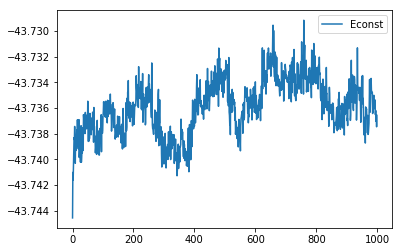

In [89]:
navg = 1
#plt.figure(figsize=(12,8))
#plt.plot(movingaverage((en[0]), navg),label='E sys',)
#plt.plot(movingaverage((en[1]), navg),label='temperature',)
plt.plot(movingaverage((en[2]), navg),label='Econst',)
plt.legend()

In [90]:
regarder_trajectoire(pos,10)

NGLWidget(count=100)

In [40]:
aa,bb = pos[-1],vel[-1]

In [44]:
T = 0.1
#pos,vel,en1 = MD_NVT_simulator(pos[-1],vel[-1],mass=mass,r_m=r_m,epsilon=epsilon,
pos,vel,en1 = MD_NVT_simulator(aa,bb,mass=mass,r_m=r_m,epsilon=epsilon,                   
                           k_spring=k_spring,temperature=T,
                           Nstep=50000,dt=dt,thermostat_Nstep=10)

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

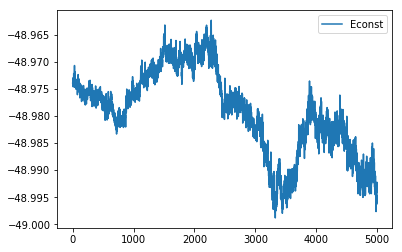

In [45]:
navg = 1
#plt.figure(figsize=(12,8))
#plt.plot(movingaverage((en1[0]), navg),label='E sys',)
#plt.plot(movingaverage((en1[1]), navg),label='temperature',)
plt.plot(movingaverage((en1[2]), navg),label='Econst',)
plt.legend()

In [46]:
view_traj(pos,10)

NGLWidget(count=500)